In [1]:
from TSP_Formulation_Methods import *
import numpy as np

distances_original_matrix = np.loadtxt("./data/matriz-rutas-granada")

# Global Parameters

N = 4 # Number of stops
p = 2 # Number of travels, aka number of edges. The number of involucred stops is then p+1
startNode = 1
endNode = 3

# Process Parameters

p = min(p, N-1)
startNode = min(startNode, N-1)
endNode = min(endNode, N-1)

distances_N_stops_normalized = distances_original_matrix[:N,:N]/np.max(distances_original_matrix[:N,:N])


Optimized solution:
[1 0 0 0 0 0 1 0 0 0 0 0 0 0 1]

Optimized solution cost:
1.449521410098581

Optimized solution total cost:
2.839808373176062

Validity of the solution:
True


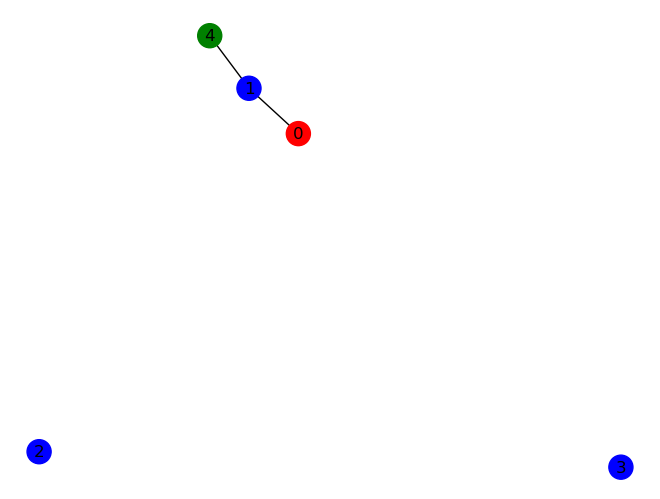

In [2]:
# Naive solution

naive_solution = generate_valid_initial_solution(N, p, startNode, endNode)

show_parameters_of_solution(naive_solution, distances_N_stops_normalized, N, p, startNode, endNode)

draw_solution_graph(naive_solution, distances_N_stops_normalized, p, startNode, endNode)


Optimized solution:
[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1]

Optimized solution cost:
0.5084218462213824

Optimized solution total cost:
1.0002385792130704

Lambdas:
[1.56877627950032, 0.9687762795003195, 0.46877627950031964, 0.36877627950031966, 0.36877627950031966]

Validity of the solution:
True

Q matrix of optimized solution:
[[-5.21265768  2.53755256  2.53755256  2.53755256  2.53755256  1.43755256
   1.57693378  1.22080182  1.21663145  1.36378711  1.43755256  0.96877628
   0.96877628  0.96877628  0.96877628]
 [ 2.53755256 -4.8438814   2.53755256  2.53755256  2.53755256  1.35906324
   1.43755256  1.59586743  1.16348555  1.81014019  0.96877628  1.43755256
   0.96877628  0.96877628  0.96877628]
 [ 2.53755256  2.53755256 -4.8438814   2.53755256  2.53755256  1.21643105
   1.64302022  1.43755256  1.42886198  1.22517259  0.96877628  0.96877628
   1.43755256  0.96877628  0.96877628]
 [ 2.53755256  2.53755256  2.53755256 -4.8438814   2.53755256  1.1873721
   1.17923177  1.52327254  1.43755256  1

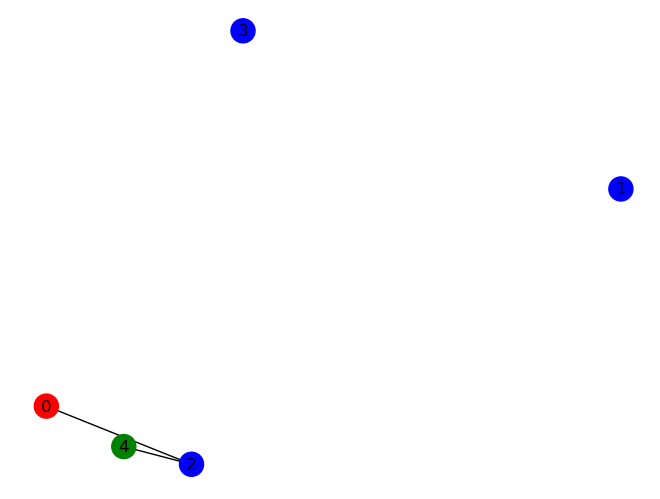

In [3]:
scalingFactor = 0.1
max_iterations = 1000
num_reads = 1000

optimized_solution, optimized_lambdas = find_optimized_solution(distances_N_stops_normalized, p, N, startNode, endNode, scalingFactor, max_iterations, num_reads)

Q_matrix_optimized, optimized_solution_cost, optimized_solution_total_cost = show_parameters_of_solution(optimized_solution, distances_N_stops_normalized, N, p, startNode, endNode, optimized_lambdas)

print("\nQ matrix of optimized solution:")
print(Q_matrix_optimized)

draw_solution_graph(optimized_solution, distances_N_stops_normalized, p, startNode, endNode)


Optimized solution:
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

Optimized solution cost:
0.0

Optimized solution total cost:
0.46629830036168607

Validity of the solution:
False


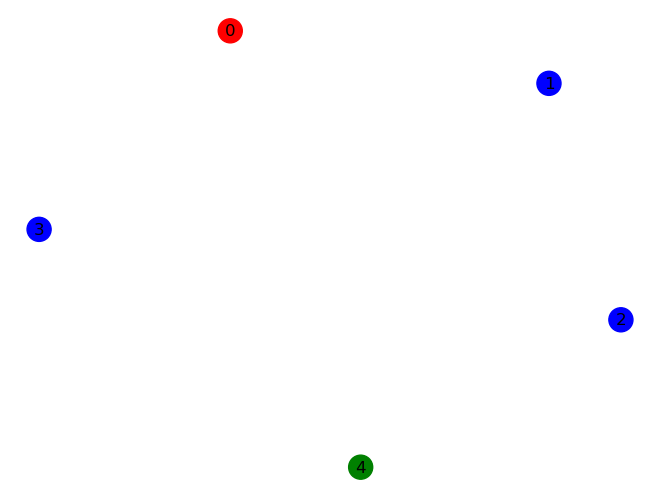

In [4]:
combinations_zipped = brute_force_finding(Q_matrix_optimized, distances_N_stops_normalized, p)

global_minimum = np.array(list(combinations_zipped[0][0]), dtype=int)

show_parameters_of_solution(global_minimum, distances_N_stops_normalized, N, p, startNode, endNode)

draw_solution_graph(global_minimum, distances_N_stops_normalized, p, startNode, endNode)

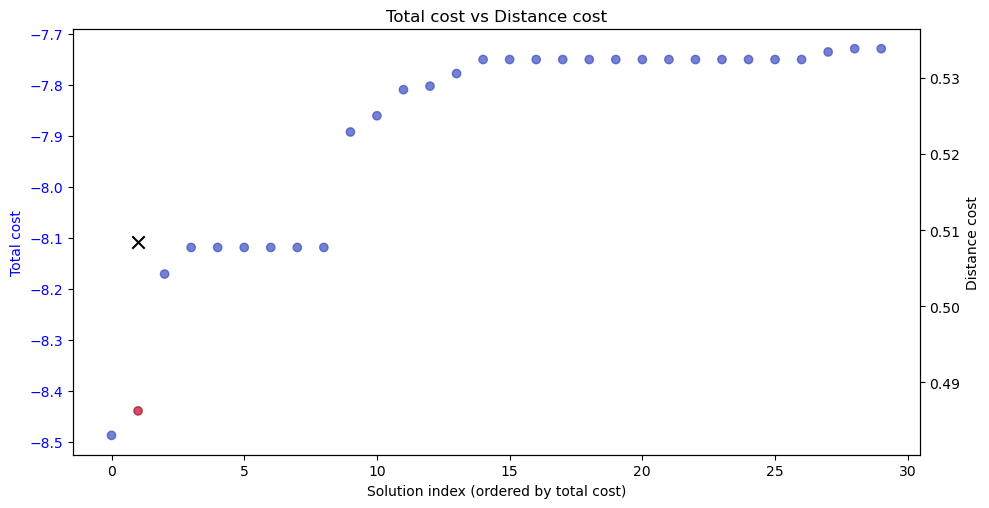

In [5]:
rangePlot = 30

plot_brute_force_minimums(combinations_zipped, N, p, startNode, endNode, rangePlot=rangePlot)

violation_of_constraints = count_most_violated_constraints(combinations_zipped, N, p, startNode, endNode, plotRange=rangePlot)

initial_lambdas = [optimized_lambdas[i]+violation_of_constraints[i] for i in range(5)]


Optimized solution:
[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1]

Optimized solution cost:
0.5084218462213824

Optimized solution total cost:
1.0002385792130704

Lambdas:
[2.868776279500321, 1.6354429461669862, 0.5354429461669863, 1.0687762795003195, 1.202109612833653]

Validity of the solution:
True

Q matrix of optimized solution:
[[-9.24599101  4.50421923  4.50421923  4.50421923  4.50421923  2.17088589
   2.24360045  1.88746848  1.88329812  2.03045378  2.17088589  1.63544295
   1.63544295  1.63544295  1.63544295]
 [ 4.50421923 -8.17721473  4.50421923  4.50421923  4.50421923  2.02572991
   2.17088589  2.26253409  1.83015221  2.47680686  1.63544295  2.17088589
   1.63544295  1.63544295  1.63544295]
 [ 4.50421923  4.50421923 -8.17721473  4.50421923  4.50421923  1.88309771
   2.30968689  2.17088589  2.09552864  1.89183925  1.63544295  1.63544295
   2.17088589  1.63544295  1.63544295]
 [ 4.50421923  4.50421923  4.50421923 -8.17721473  4.50421923  1.85403876
   1.84589844  2.18993921  2.17088589  2.4

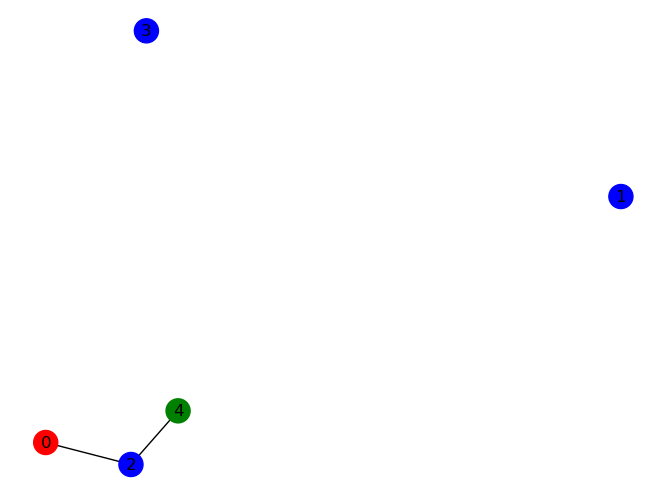

In [6]:
# Repeat the process with new initial lambdas

optimized_solution, optimized_lambdas = find_optimized_solution(distances_N_stops_normalized, p, N, startNode, endNode, scalingFactor, max_iterations, num_reads, initial_lambdas)

Q_matrix_optimized, optimized_solution_cost, optimized_solution_total_cost = show_parameters_of_solution(optimized_solution, distances_N_stops_normalized, N, p, startNode, endNode, optimized_lambdas)

print("\nQ matrix of optimized solution:")
print(Q_matrix_optimized)

draw_solution_graph(optimized_solution, distances_N_stops_normalized, p, startNode, endNode)


Optimized solution:
[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1]

Optimized solution cost:
0.5084218462213824

Optimized solution total cost:
1.0002385792130704

Validity of the solution:
True


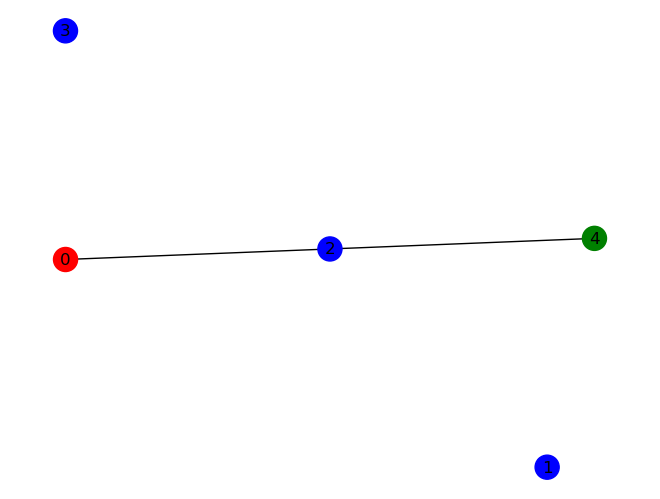

In [7]:
combinations_zipped = brute_force_finding(Q_matrix_optimized, distances_N_stops_normalized, p)

global_minimum = np.array(list(combinations_zipped[0][0]), dtype=int)

show_parameters_of_solution(global_minimum, distances_N_stops_normalized, N, p, startNode, endNode)

draw_solution_graph(global_minimum, distances_N_stops_normalized, p, startNode, endNode)

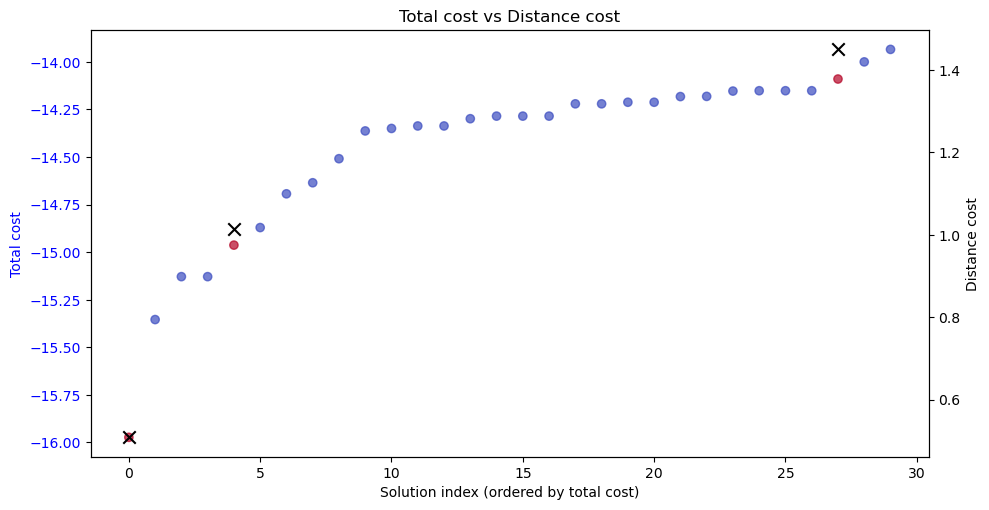

In [8]:
plot_brute_force_minimums(combinations_zipped, N, p, startNode, endNode, rangePlot=rangePlot)

In [10]:
# Iterate the whole process

iterations_process = 5
scalingFactor = 0.1
max_iterations_per_process = 10
num_reads_solver = 1000
rangePlot = 30

optimized_solution, optimized_lambdas = find_optimized_solution(distances_N_stops_normalized, p, N, startNode, endNode, scalingFactor, max_iterations_per_process, num_reads_solver)

Q_matrix_optimized,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, optimized_lambdas)

combinations_zipped = brute_force_finding(Q_matrix_optimized, distances_N_stops_normalized, p)

violation_of_constraints = count_most_violated_constraints(combinations_zipped, N, p, startNode, endNode, plotRange=rangePlot)

initial_lambdas = [optimized_lambdas[i]+violation_of_constraints[i] for i in range(5)]

for i in range(iterations_process-1):
    optimized_solution, optimized_lambdas = find_optimized_solution(distances_N_stops_normalized, p, N, startNode, endNode, scalingFactor, max_iterations_per_process, num_reads_solver, initial_lambdas)

    Q_matrix_optimized,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, optimized_lambdas)

    combinations_zipped = brute_force_finding(Q_matrix_optimized, distances_N_stops_normalized, p)

    if i != iterations_process-2:
        violation_of_constraints = count_most_violated_constraints(combinations_zipped, N, p, startNode, endNode, plotRange=rangePlot)
        initial_lambdas = [optimized_lambdas[i]+violation_of_constraints[i] for i in range(5)]

    

No solution found
No solution found
No solution found
No solution found



Optimized solution:
[0 1 0 0 1 0 0 0 0 0 0 1]

Optimized solution cost:
0.94645586819906

Optimized solution total cost:
2.1726490403668683

Lambdas:
[5.077979958104511, 2.6779799581045123, 1.577979958104512, 2.6113132914378454, 3.8113132914378456]

Validity of the solution:
True

Q matrix of optimized solution:
[[-13.38989979   7.75595992   7.75595992   7.75595992   4.25595992
    3.57996433   3.0517698    3.04558456   4.25595992   2.67797996
    2.67797996   2.67797996]
 [  7.75595992 -16.00121308   7.75595992   7.75595992   3.25683123
    4.25595992   3.60804563   2.96676159   2.67797996   4.25595992
    2.67797996   2.67797996]
 [  7.75595992   7.75595992 -13.38989979   7.75595992   3.04528732
    3.67797996   4.25595992   3.36035271   2.67797996   2.67797996
    4.25595992   2.67797996]
 [  7.75595992   7.75595992   7.75595992 -13.38989979   3.00218876
    2.9901155    3.50037706   4.25595992   2.67797996   2.67797996
    2.67797996   4.25595992]
 [  4.25595992   3.25683123   3.0

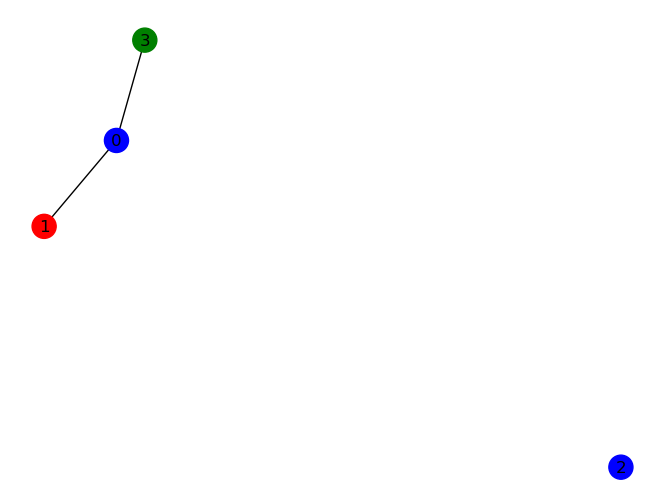

In [11]:
Q_matrix_optimized, optimized_solution_cost, optimized_solution_total_cost = show_parameters_of_solution(optimized_solution, distances_N_stops_normalized, N, p, startNode, endNode, optimized_lambdas)

print("\nQ matrix of optimized solution:")
print(Q_matrix_optimized)

draw_solution_graph(optimized_solution, distances_N_stops_normalized, p, startNode, endNode)


Optimized solution:
[0 1 0 0 1 0 0 0 0 0 0 1]

Optimized solution cost:
0.94645586819906

Optimized solution total cost:
2.1726490403668683

Validity of the solution:
True


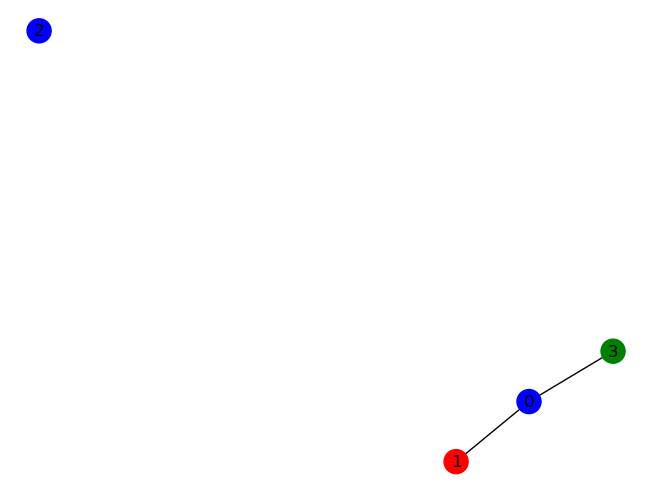

In [12]:
global_minimum = np.array(list(combinations_zipped[0][0]), dtype=int)

show_parameters_of_solution(global_minimum, distances_N_stops_normalized, N, p, startNode, endNode)

draw_solution_graph(global_minimum, distances_N_stops_normalized, p, startNode, endNode)

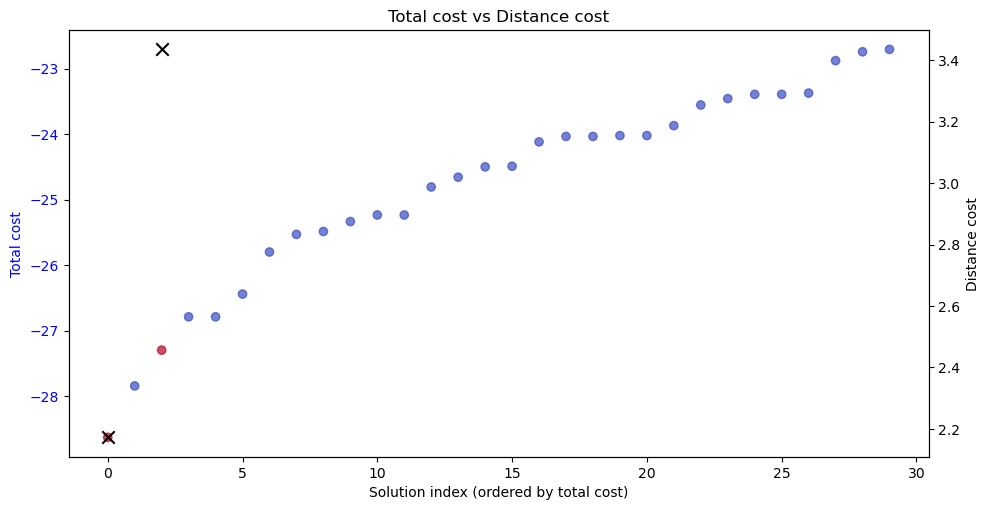

In [13]:
plot_brute_force_minimums(combinations_zipped, N, p, startNode, endNode, rangePlot=rangePlot)

In [14]:
# Store the lambdas in a file, to be used in the next iteration.
# We use the naming to store the lambdas in a folder with the same name as the parameters of the problem
# Create the folder data/lambdasOptimized if it does not exist
import os
try:
    os.mkdir("./data/lamdasOptimized")
except:
    pass

np.savetxt("./data/lamdasOptimized/lambdas_N_{}_p_{}_startNode_{}_endNode_{}".format(N, p,startNode,endNode ), optimized_lambdas, delimiter=",")

In [2]:
# Automatized process to generate all combinations of parameters

N = 5
L = 1
p = 2

all_start_end_combinations = generate_all_start_end_combinations(N, L)

iterations_process = 5
scalingFactor = 0.1
max_iterations_per_process = 10
num_reads_solver = 1000
rangePlot = 30

for startNodes, endNodes in all_start_end_combinations:
    startNode = startNodes[0]
    endNode = endNodes[0]
    distances_N_stops_normalized = distances_original_matrix[:N,:N]/np.max(distances_original_matrix[:N,:N])

    optimized_solution, optimized_lambdas = find_optimized_solution(distances_N_stops_normalized, p, N, startNode, endNode, scalingFactor, max_iterations_per_process, num_reads_solver)

    Q_matrix_optimized,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, optimized_lambdas)

    combinations_zipped = brute_force_finding(Q_matrix_optimized, distances_N_stops_normalized, p)

    violation_of_constraints = count_most_violated_constraints(combinations_zipped, N, p, startNode, endNode, plotRange=rangePlot)

    initial_lambdas = [optimized_lambdas[i]+violation_of_constraints[i] for i in range(5)]

    for i in range(iterations_process-1):
        optimized_solution, optimized_lambdas = find_optimized_solution(distances_N_stops_normalized, p, N, startNode, endNode, scalingFactor, max_iterations_per_process, num_reads_solver, initial_lambdas)

        Q_matrix_optimized,_ = create_QUBO_matrix(distances_N_stops_normalized, p, startNode, endNode, optimized_lambdas)

        combinations_zipped = brute_force_finding(Q_matrix_optimized, distances_N_stops_normalized, p)

        if i != iterations_process-2:
            violation_of_constraints = count_most_violated_constraints(combinations_zipped, N, p, startNode, endNode, plotRange=rangePlot)
            initial_lambdas = [optimized_lambdas[i]+violation_of_constraints[i] for i in range(5)]

    np.savetxt("./data/lamdasOptimized/lambdas_N_{}_p_{}_startNode_{}_endNode_{}".format(N, p,startNode,endNode ), optimized_lambdas, delimiter=",")


No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
No solution found
